In [1]:
def extract_zip(zip_path):
    import zipfile
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()

extract_zip('Autistic.zip')
extract_zip('Non_Autistic.zip')

In [2]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="dataset")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2940
    })
})

In [4]:
dataset = dataset['train']
dataset = dataset.train_test_split(test_size=0.1)

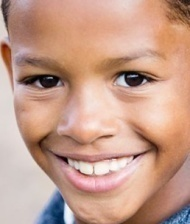

In [5]:
dataset['train']['image'][0]

In [6]:
dataset['train'].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Autistic', 'Non_Autistic'], id=None)}

In [7]:
train_ds = dataset['train']
val_ds = dataset['test']

In [8]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'Autistic', 1: 'Non_Autistic'}

In [9]:
id2label[train_ds[0]['label']]

'Non_Autistic'

In [10]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [11]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [12]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

In [13]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [14]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [15]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-trainer",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=30,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate each metric
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')      # Use 'weighted' for class imbalance
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [21]:
import torch
from transformers import EarlyStoppingCallback

early_stopping_callback = EarlyStoppingCallback(5, 1.0)

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
    callbacks=[early_stopping_callback]
)

/var/folders/6v/2g3_sk3n2knc10r69qj9335c0000gn/T/ipykernel_35557/1106868179.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.428517,0.799320,0.794522,0.823331,0.799320
2,0.473000,0.356679,0.836735,0.836735,0.837975,0.836735
3,0.473000,0.391216,0.846939,0.845008,0.860293,0.846939
4,0.353900,0.398620,0.836735,0.834271,0.852681,0.836735
5,0.353900,0.477047,0.809524,0.802874,0.848882,0.809524
6,0.315000,0.344974,0.860544,0.860439,0.863711,0.860544


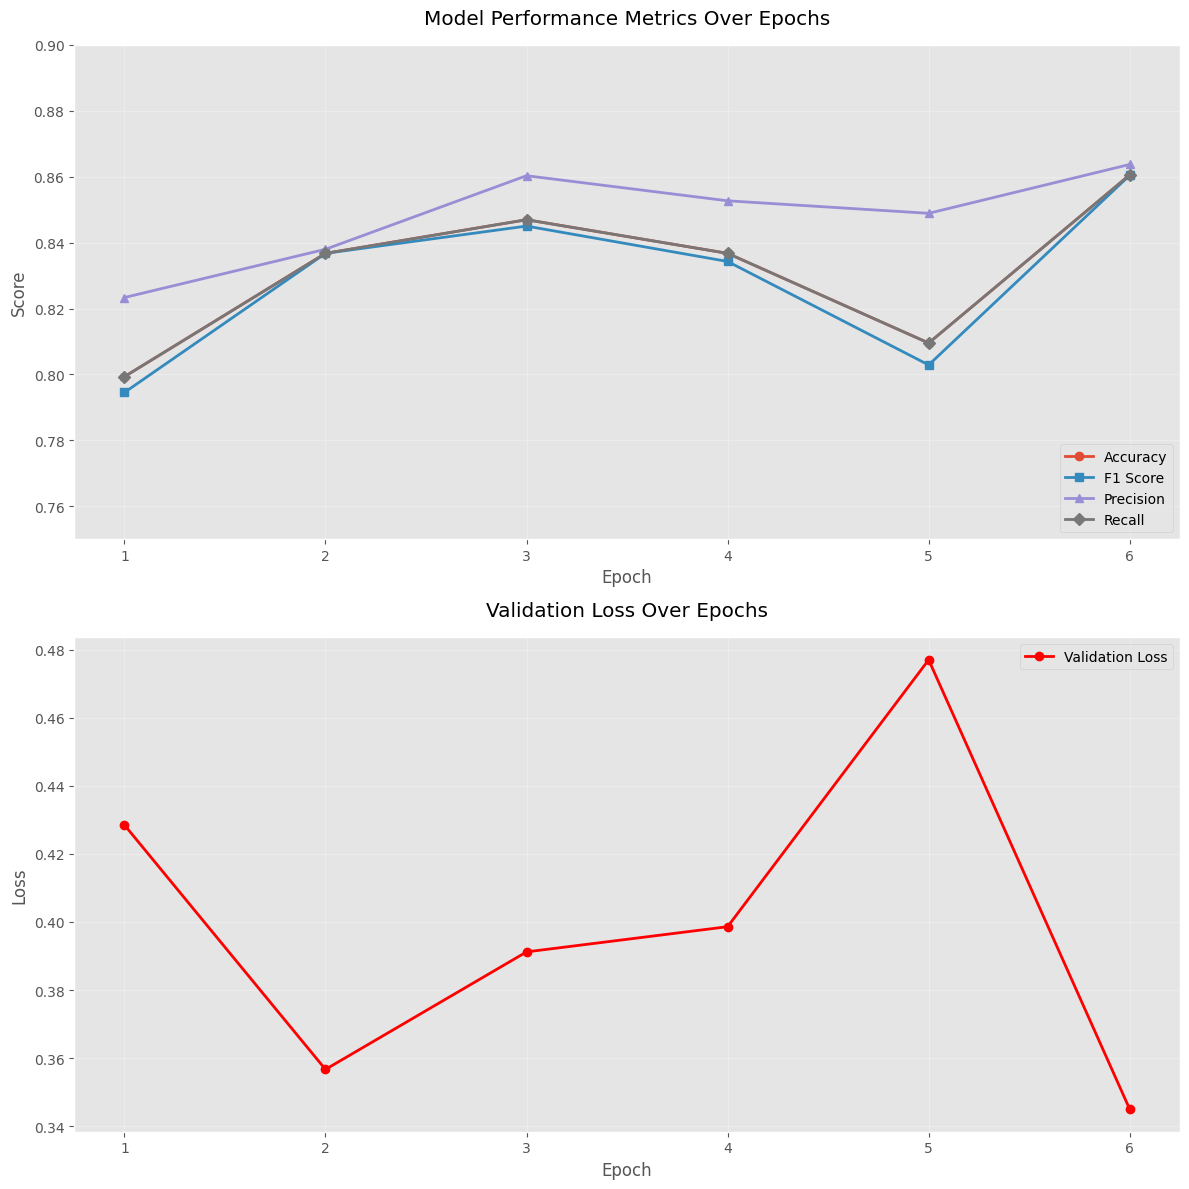


Final Metrics (Epoch 6):
Accuracy: 0.8605
F1 Score: 0.8604
Precision: 0.8637
Recall: 0.8605
Validation Loss: 0.3450


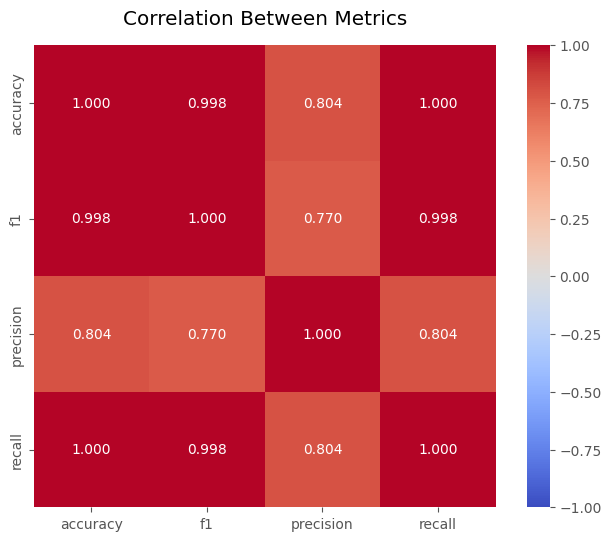

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create the viz data
data = {
    'epoch': [1, 2, 3, 4, 5, 6],
    'validation_loss': [0.428517, 0.356679, 0.391216, 0.398620, 0.477047, 0.344974],
    'accuracy': [0.799320, 0.836735, 0.846939, 0.836735, 0.809524, 0.860544],
    'f1': [0.794522, 0.836735, 0.845008, 0.834271, 0.802874, 0.860439],
    'precision': [0.823331, 0.837975, 0.860293, 0.852681, 0.848882, 0.863711],
    'recall': [0.799320, 0.836735, 0.846939, 0.836735, 0.809524, 0.860544]
}

df = pd.DataFrame(data)

# Use a built-in matplotlib style
plt.style.use('ggplot')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot performance metrics
ax1.plot(df['epoch'], df['accuracy'], marker='o', label='Accuracy', linewidth=2)
ax1.plot(df['epoch'], df['f1'], marker='s', label='F1 Score', linewidth=2)
ax1.plot(df['epoch'], df['precision'], marker='^', label='Precision', linewidth=2)
ax1.plot(df['epoch'], df['recall'], marker='D', label='Recall', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Score')
ax1.set_title('Model Performance Metrics Over Epochs', pad=15)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right')
ax1.set_ylim(0.75, 0.9)  # Set y-axis limits for better visibility of differences

# Plot validation loss
ax2.plot(df['epoch'], df['validation_loss'], marker='o', color='red', 
         label='Validation Loss', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Validation Loss Over Epochs', pad=15)
ax2.grid(True, alpha=0.3)
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

# Print final metrics
print("\nFinal Metrics (Epoch 6):")
print(f"Accuracy: {df['accuracy'].iloc[-1]:.4f}")
print(f"F1 Score: {df['f1'].iloc[-1]:.4f}")
print(f"Precision: {df['precision'].iloc[-1]:.4f}")
print(f"Recall: {df['recall'].iloc[-1]:.4f}")
print(f"Validation Loss: {df['validation_loss'].iloc[-1]:.4f}")

# Create a correlation heatmap
plt.figure(figsize=(8, 6))
metrics_corr = df[['accuracy', 'f1', 'precision', 'recall']].corr()
sns.heatmap(metrics_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            square=True, fmt='.3f')
plt.title('Correlation Between Metrics', pad=15)
plt.show()